In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

foldername = "good-results/sceptr/trained-sceptr-caneval"

dirs = Path.cwd() / foldername
rolling_window = 25
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams["figure.autolayout"] = True

endofepoch = False

In [2]:
epochs = list(dirs.glob("Epoch */*.csv"))
stats = {
    "train-acc.csv": [],
    "train-loss.csv": [],
    "test-acc.csv": [],
    "test-loss.csv": [],
}
epochwisestats = {
    "train-acc.csv": [],
    "train-loss.csv": [],
    "test-acc.csv": [],
    "test-loss.csv": [],
}
aucstats = {
    "train-preds.csv": [],
    "test-preds.csv": [],
}
epochwiseauc = {
    "train-preds.csv": {},
    "test-preds.csv": {},
}
trainseps = 0
testseps = 0


maxepochs = -1
for i in epochs:
    info = str(i).replace(str(dirs) + "\\", "").split("\\")
    info = [int(info[0].replace("Epoch ", "")), info[1]]
    df = pd.read_csv(i, header = None if "pred" not in info[1] else 0) 
    if "loss" in info[1]:
        epochwisestats[info[1]].append(
            (info[0], df.mean().values.tolist()[0]) if not endofepoch else
              (info[0], df.values[-rolling_window:].mean().tolist())
        )
        df = df.rolling(window = rolling_window).mean().dropna()

        if "train" in info[1]:
            trainseps = len(df.T.values[0].tolist()) if trainseps == 0 else trainseps
        elif "test" in info[1]:
            testseps = len(df.T.values[0].tolist()) if trainseps == 0 else testseps

        stats[info[1]].append((info[0], df.T.values[0].tolist()))
        
    elif "acc" in info[1]:
        epochwisestats[info[1]].append((info[0], df.mean().values.tolist()[0]))
        df = df.rolling(window = rolling_window).mean().dropna()
        stats[info[1]].append((info[0], df.T.values[0].tolist()))
        
        if "train" in info[1]:
            trainseps = len(df.T.values[0].tolist()) if trainseps == 0 else trainseps
        elif "test" in info[1]:
            testseps = len(df.T.values[0].tolist()) if trainseps == 0 else testseps

    elif "pred" in info[1]:
        epochwiseauc[info[1]][info[0]] = roc_curve(df["actual"], df["preds"])
        aucstats[info[1]].append((info[0], roc_auc_score(df["actual"], df["preds"])))

    maxepochs = max(maxepochs, info[0])

for key in stats.keys():
    stats[key].sort(key = lambda x: x[0])
    stats[key] = sum([i[1] for i in stats[key]], [])

for key in aucstats.keys():
    aucstats[key].sort(key = lambda x: x[0])
    aucstats[key] = [i[1] for i in aucstats[key]]

for key in epochwisestats.keys():
    epochwisestats[key].sort(key = lambda x: x[0])
    epochwisestats[key] = [i[1] for i in epochwisestats[key]]

bestepoch = np.argmax(aucstats['test-preds.csv'][10:]) + 10
bestepoch

print (f"Best Epoch is {bestepoch}")

Best Epoch is 41


In [3]:
from src.model import unidirectional, load_trained

dirs = Path.cwd() / foldername
similarity = {}
if "unidirectional" in str(dirs):
    for i in epochs:
        e = int(str(i).replace(str(dirs) + "\\", "").split("\\")[0].replace("Epoch ", ""))
        model = dirs / f"Epoch {e}" / f"classifier-{e}.pth"
        model = load_trained(model, unidirectional)

        scoring_weights = np.array(model.scoring_linear1.weight.tolist()[0])
        classify_weights = np.array(model.classifying_linear1.weight.tolist()[0])

        scoring_weights /= np.linalg.norm(scoring_weights)
        classify_weights /= np.linalg.norm(classify_weights)

        similarity[e] = np.dot(scoring_weights, classify_weights)

    similarity = list(similarity.items())
    similarity.sort(key = lambda x: x[0])

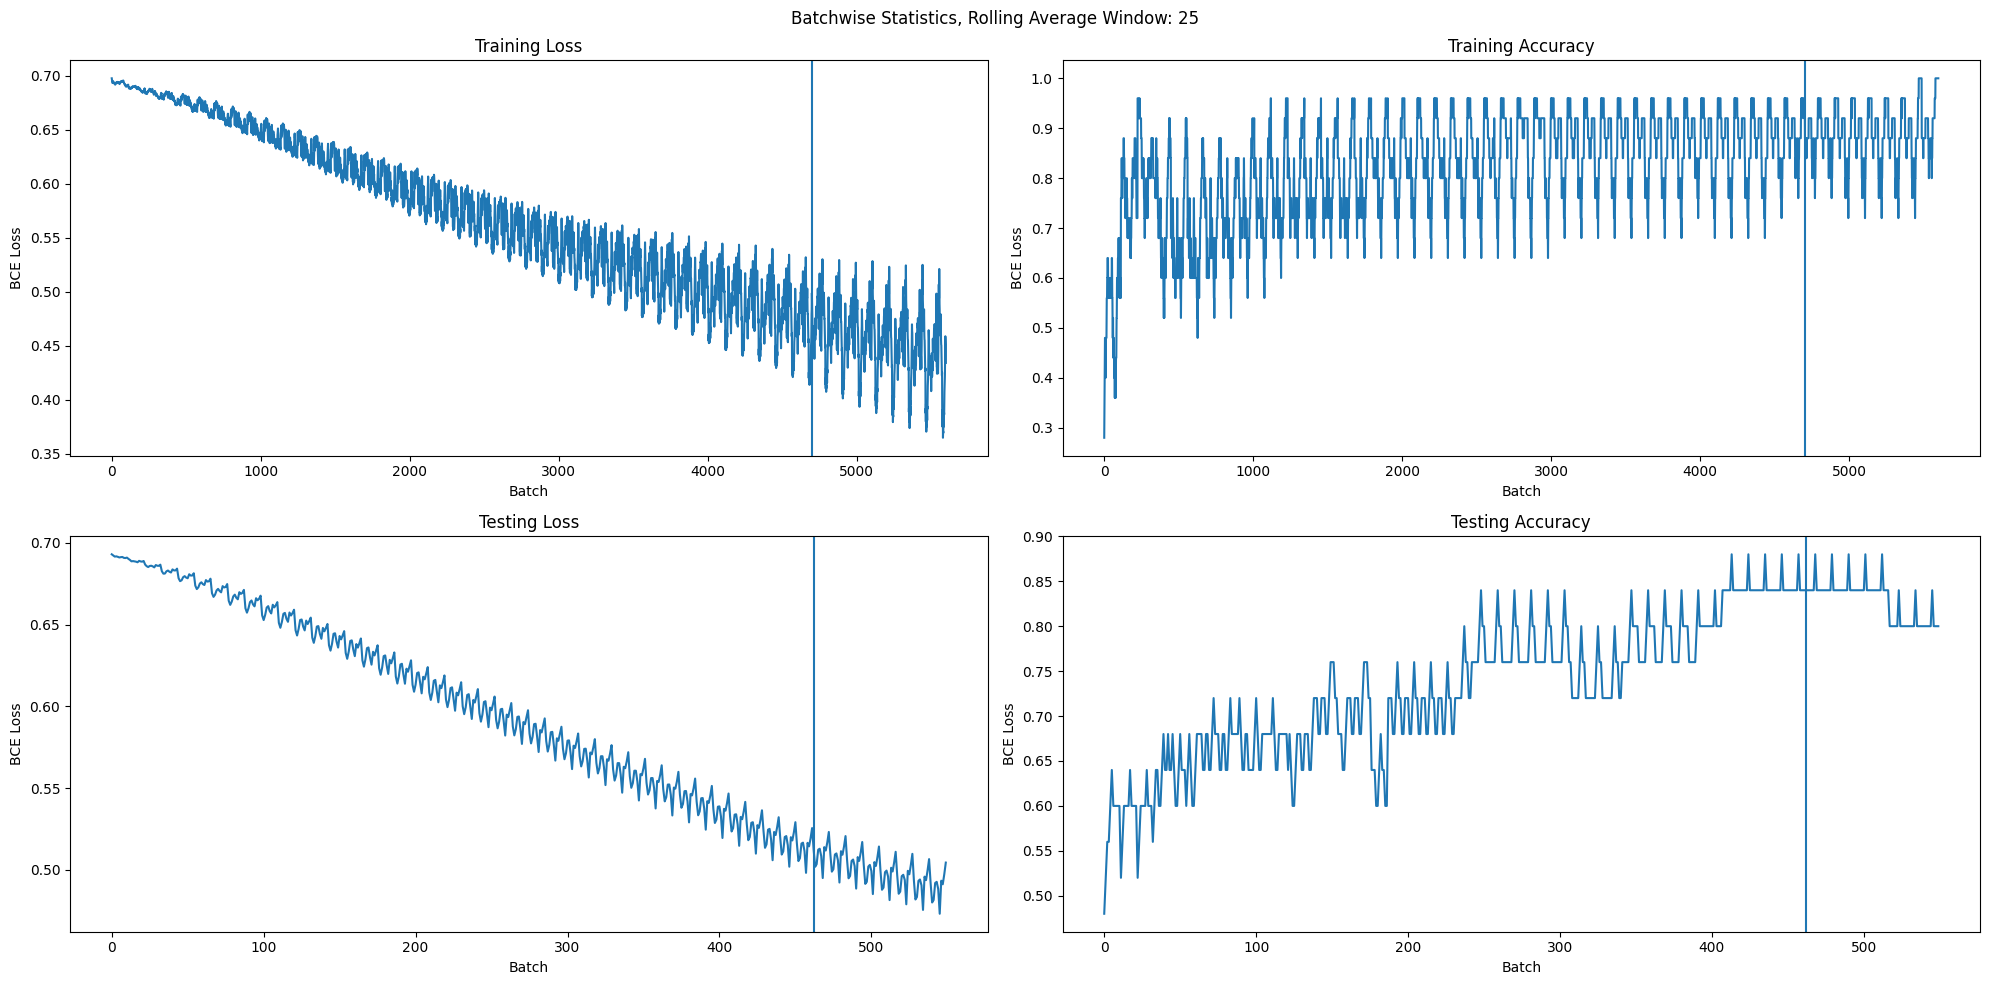

In [4]:
fig, axs = plt.subplots(ncols = 2, nrows = 2)
axs[0, 0].plot(stats["train-loss.csv"])
axs[0, 0].axvline((bestepoch + 1) * trainseps)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Batch")
axs[0, 0].set_ylabel("BCE Loss")

axs[1, 0].plot(stats["test-loss.csv"])
axs[1, 0].axvline((bestepoch + 1) * testseps)
axs[1, 0].set_title("Testing Loss")
axs[1, 0].set_xlabel("Batch")
axs[1, 0].set_ylabel("BCE Loss")

axs[0, 1].plot(stats["train-acc.csv"])
axs[0, 1].axvline((bestepoch + 1) * trainseps)
axs[0, 1].set_title("Training Accuracy")
axs[0, 1].set_xlabel("Batch")
axs[0, 1].set_ylabel("BCE Loss")

axs[1, 1].plot(stats["test-acc.csv"])
axs[1, 1].axvline((bestepoch + 1) * testseps)
axs[1, 1].set_title("Testing Accuracy")
axs[1, 1].set_xlabel("Batch")
axs[1, 1].set_ylabel("BCE Loss")

fig.suptitle(f"Batchwise Statistics, Rolling Average Window: {rolling_window}")
plt.show()

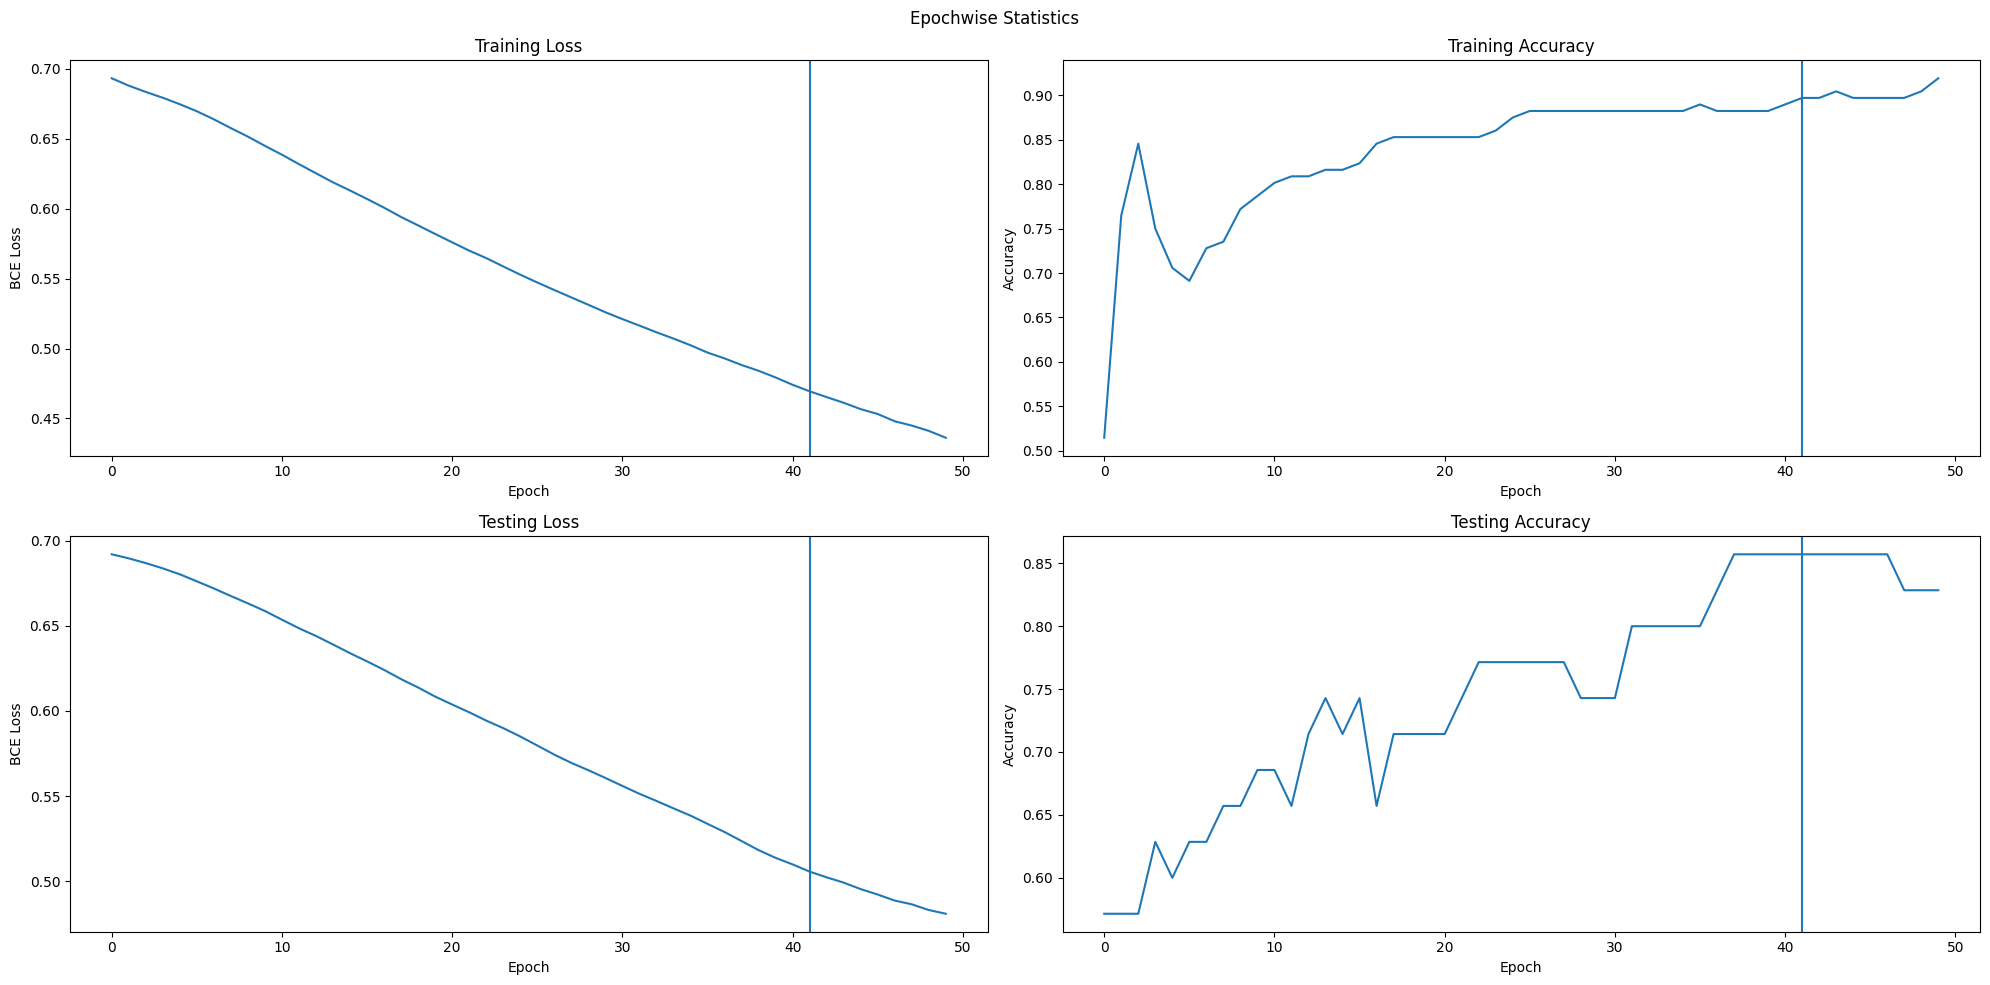

In [5]:
fig, axs = plt.subplots(ncols = 2, nrows = 2)
axs[0, 0].plot(epochwisestats["train-loss.csv"])
axs[0, 0].axvline(bestepoch)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("BCE Loss")

axs[1, 0].plot(epochwisestats["test-loss.csv"])
axs[1, 0].axvline(bestepoch)
axs[1, 0].set_title("Testing Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("BCE Loss")

axs[0, 1].plot(epochwisestats["train-acc.csv"])
axs[0, 1].axvline(bestepoch)
axs[0, 1].set_title("Training Accuracy")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy")

axs[1, 1].plot(epochwisestats["test-acc.csv"])
axs[1, 1].axvline(bestepoch)
axs[1, 1].set_title("Testing Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")

fig.suptitle(f"Epochwise Statistics")
plt.show()

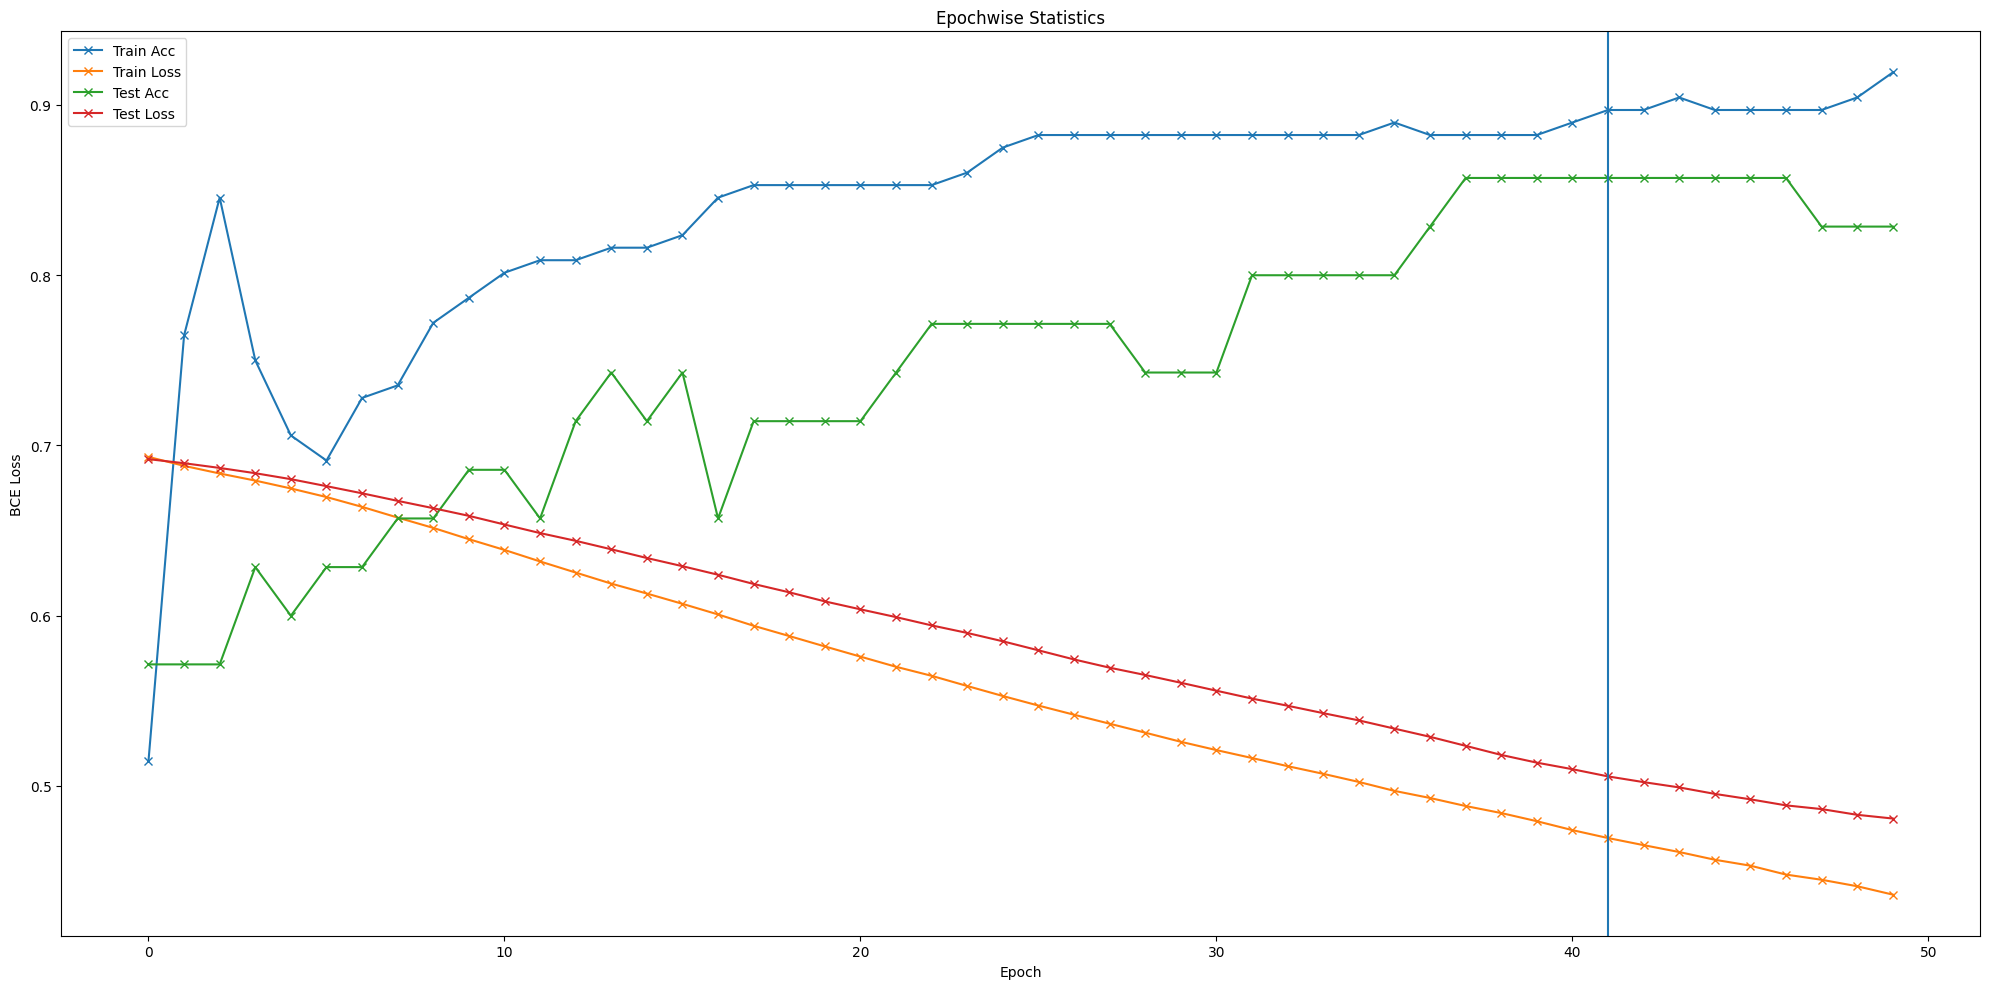

In [6]:
for key, val in epochwisestats.items():
    plt.plot(val, label = " ".join(key.replace(".csv", "").split("-")).title(), marker = "x")

plt.axvline(bestepoch)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Epochwise Statistics")
plt.legend()
plt.show()

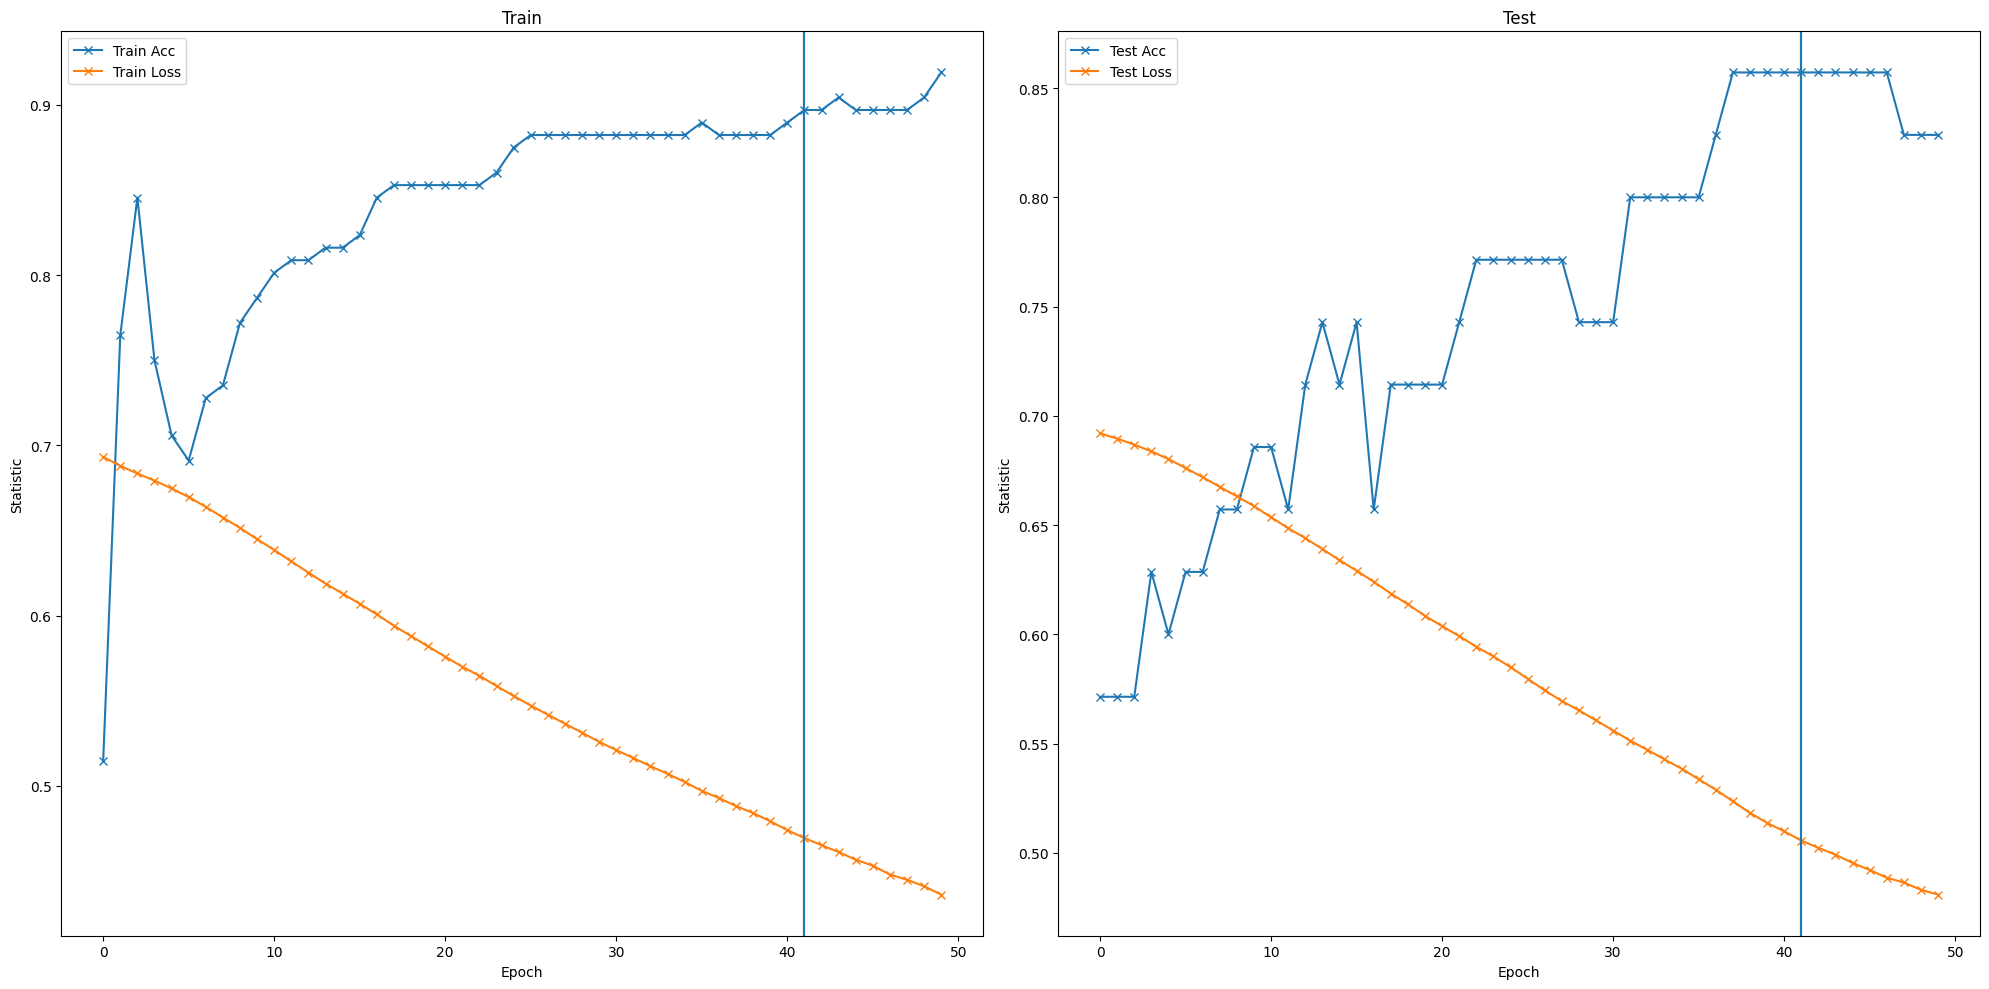

In [7]:
fig, axs = plt.subplots(ncols = 2)

for key, val in epochwisestats.items():
    axs[0 if "train" in key else 1].plot(val, label = " ".join(key.replace(".csv", "").split("-")).title(), marker = "x")
    axs[0 if "train" in key else 1].axvline(bestepoch)
    axs[0 if "train" in key else 1].set_xlabel("Epoch")
    axs[0 if "train" in key else 1].set_ylabel("Statistic")
    
axs[0].legend()
axs[1].legend()
axs[0].set_title("Train")
axs[1].set_title("Test")
plt.show()

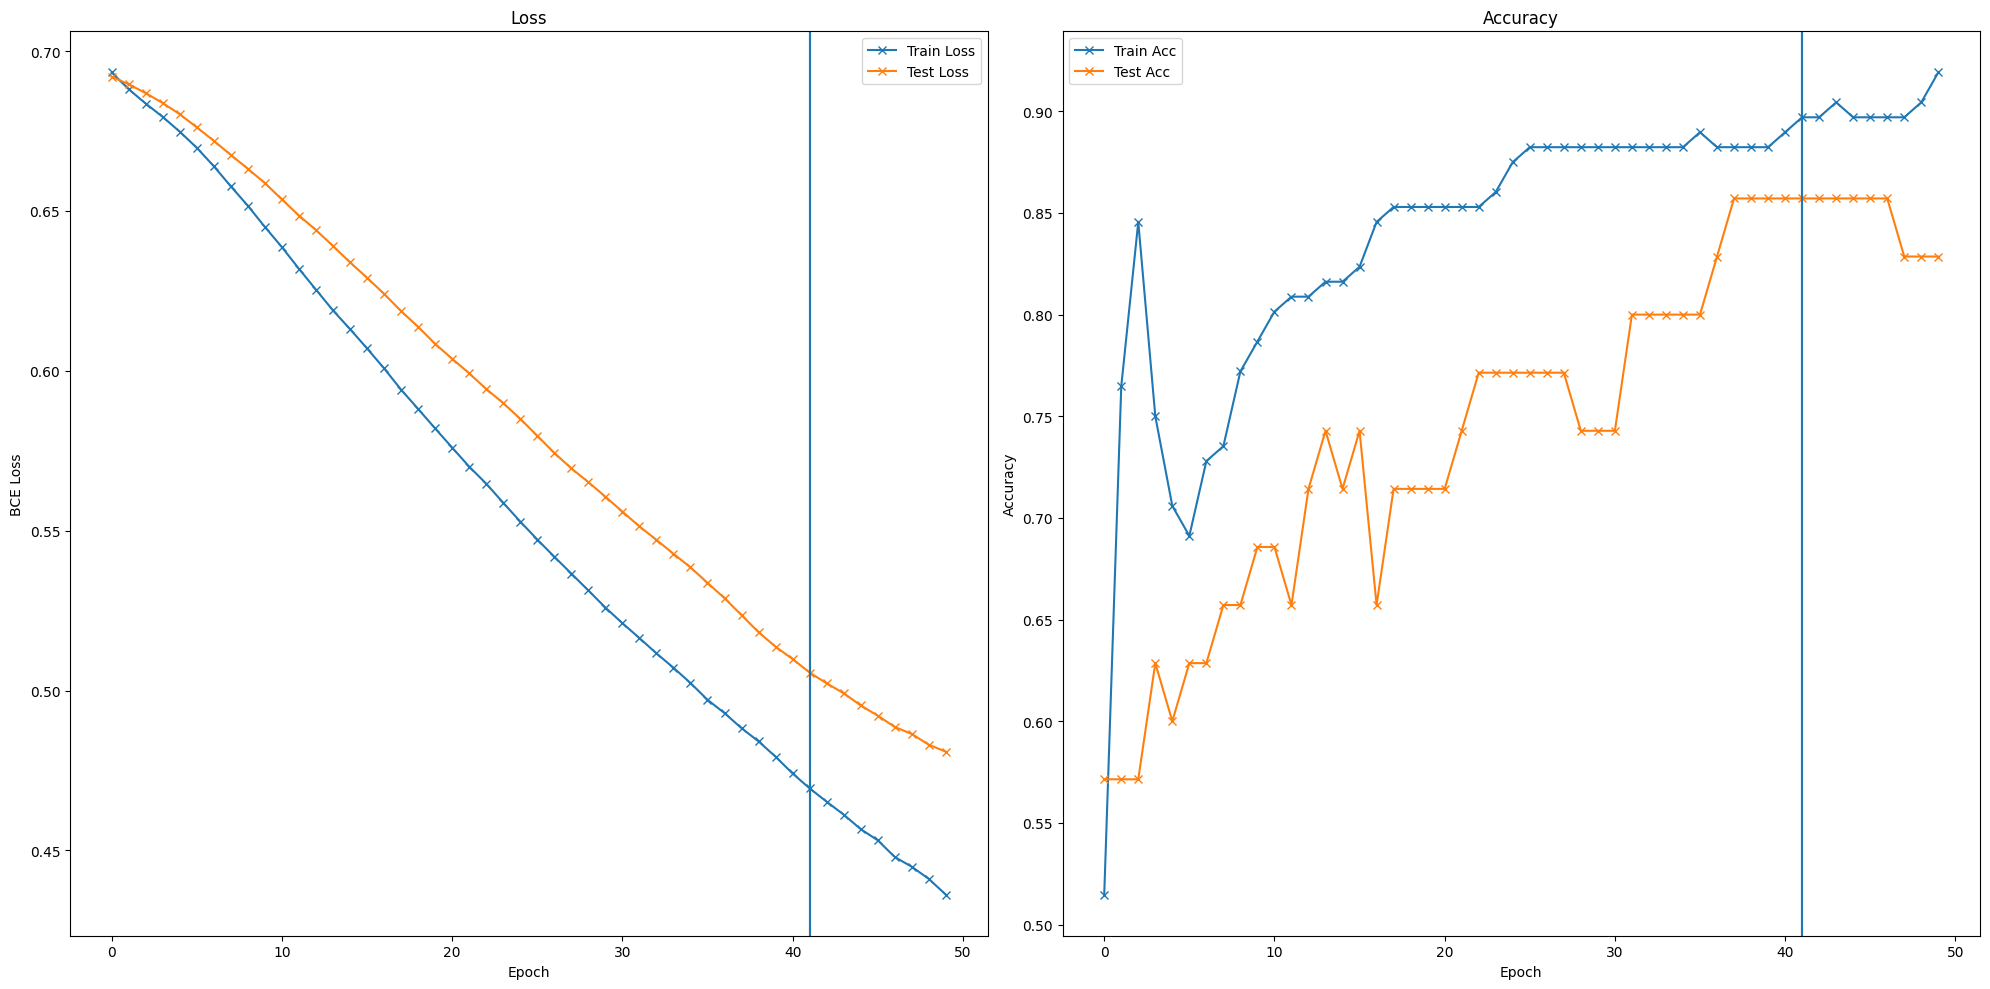

In [8]:
fig, axs = plt.subplots(ncols = 2)

for key, val in epochwisestats.items():
    axs[0 if "loss" in key else 1].plot(val, label = " ".join(key.replace(".csv", "").split("-")).title(), marker = "x")
    axs[0 if "loss" in key else 1].axvline(bestepoch)
    axs[0 if "loss" in key else 1].set_xlabel("Epoch")
    axs[0 if "loss" in key else 1].set_ylabel("BCE Loss" if "loss" in key else "Accuracy")

axs[0].legend()
axs[1].legend()
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")
plt.show()

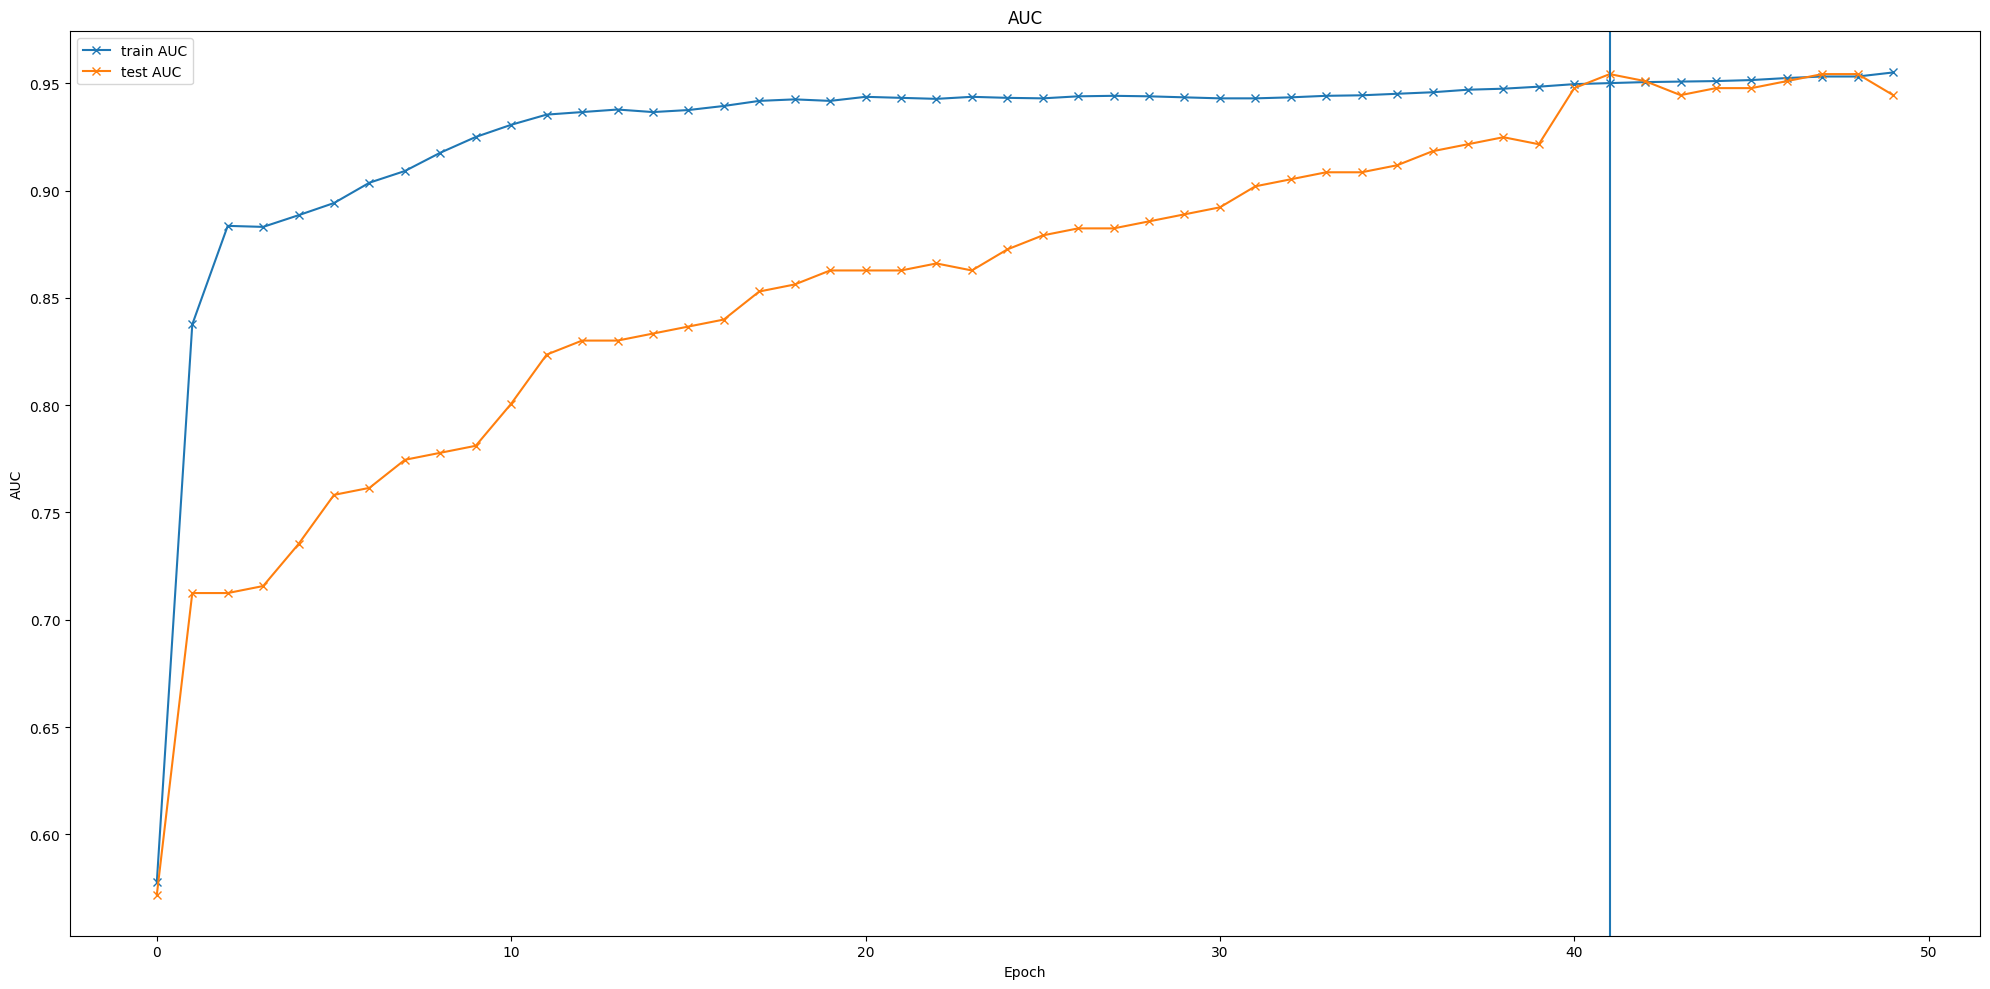

In [9]:
for key, val in aucstats.items():
    t = key.replace(".csv", "").split("-")[0]
    plt.plot(val, label = f"{t} AUC", marker = "x")

plt.axvline(bestepoch)
plt.title("AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.show()

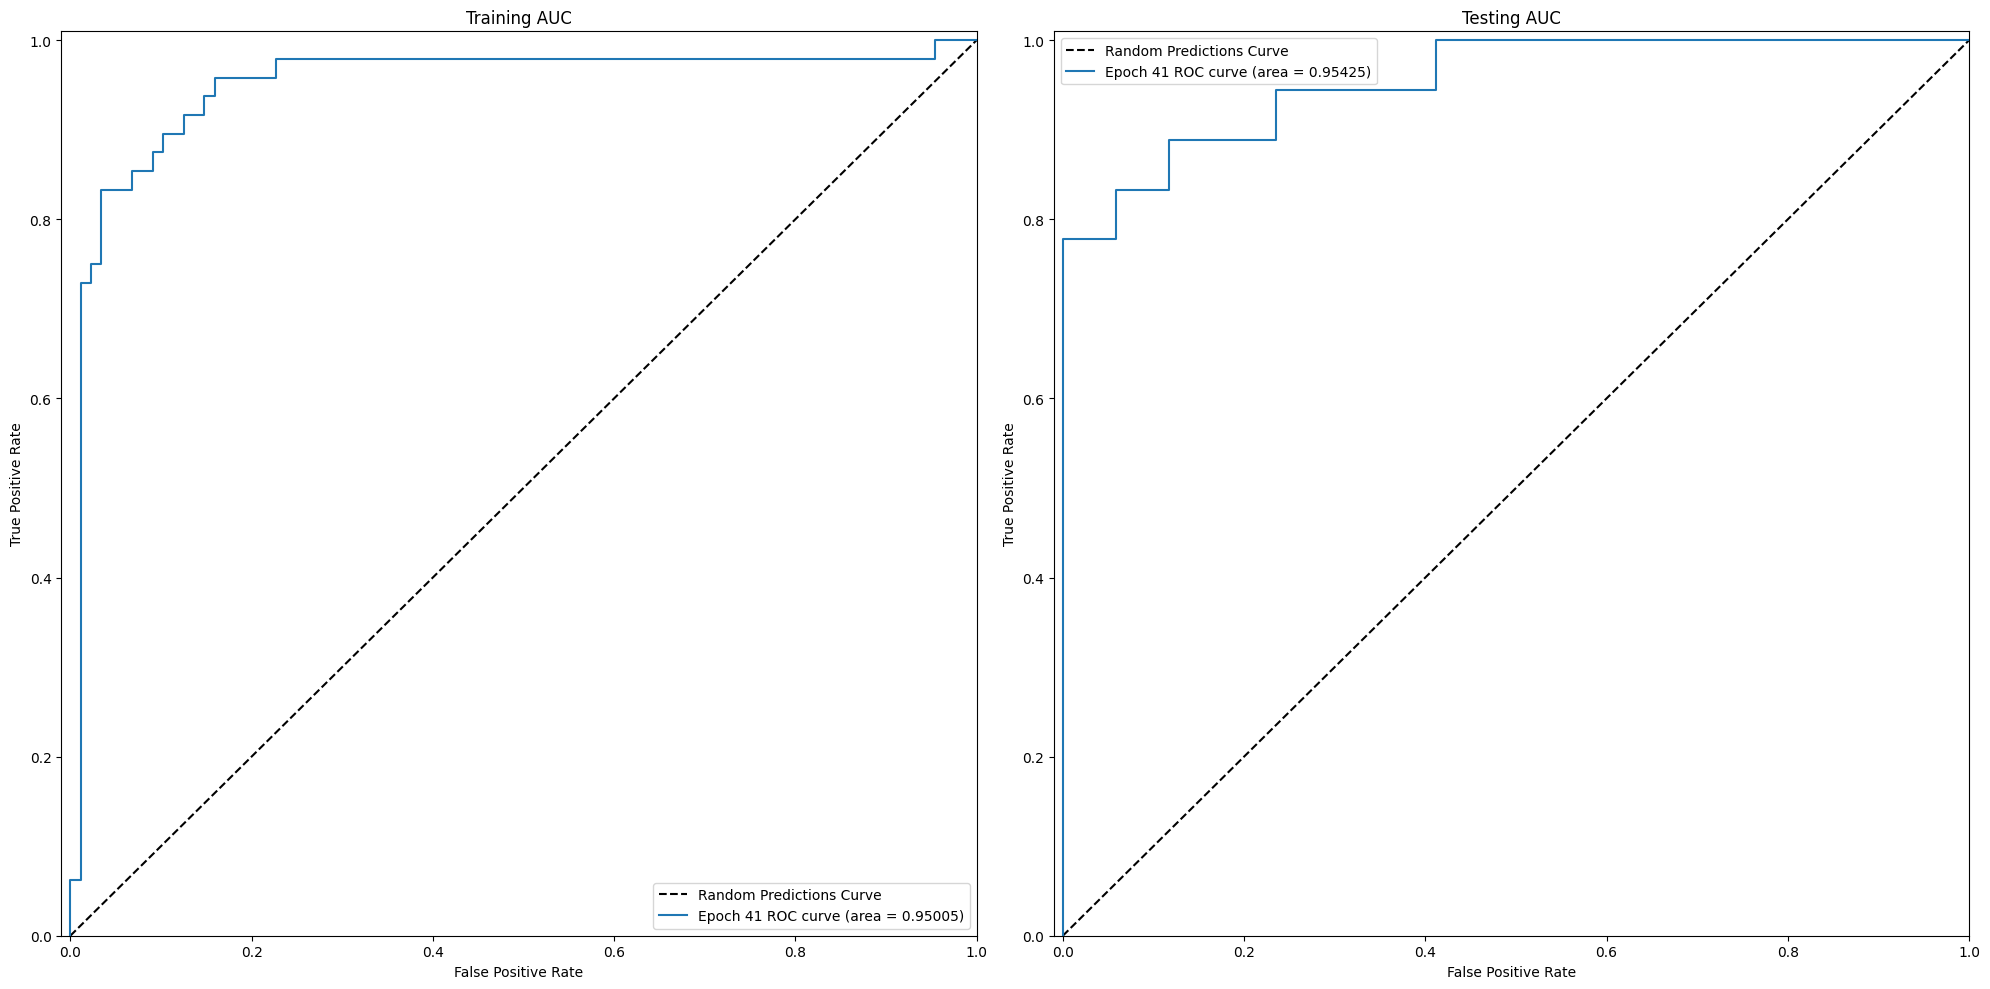

In [10]:
fig, axs = plt.subplots(ncols = 2)

axs[0].plot([0, 1], [0, 1], "k--", label = "Random Predictions Curve")
axs[1].plot([0, 1], [0, 1], "k--", label = "Random Predictions Curve")

for key in epochwiseauc.keys():
    fpr, tpr, thresholds = epochwiseauc[key][bestepoch]
    axs[0 if "train" in key else 1].plot(fpr, tpr, label = f"Epoch {bestepoch} ROC curve (area = {aucstats[key][bestepoch]:.5f})")
    axs[0 if "train" in key else 1].set_xlim([-0.01, 1])
    axs[0 if "train" in key else 1].set_ylim([0, 1.01])
    axs[0 if "train" in key else 1].set_xlabel("False Positive Rate")
    axs[0 if "train" in key else 1].set_ylabel("True Positive Rate")

axs[0].legend()
axs[1].legend()
axs[0].set_title("Training AUC")
axs[1].set_title("Testing AUC")
plt.show()

In [11]:
if similarity != {}:
    plt.plot([i[1] for i in similarity], marker = "x")
    plt.axvline(bestepoch)
    plt.xlabel("Epoch")
    plt.ylabel("Similarity Between Scoring and Classifying Vector")
    plt.show()

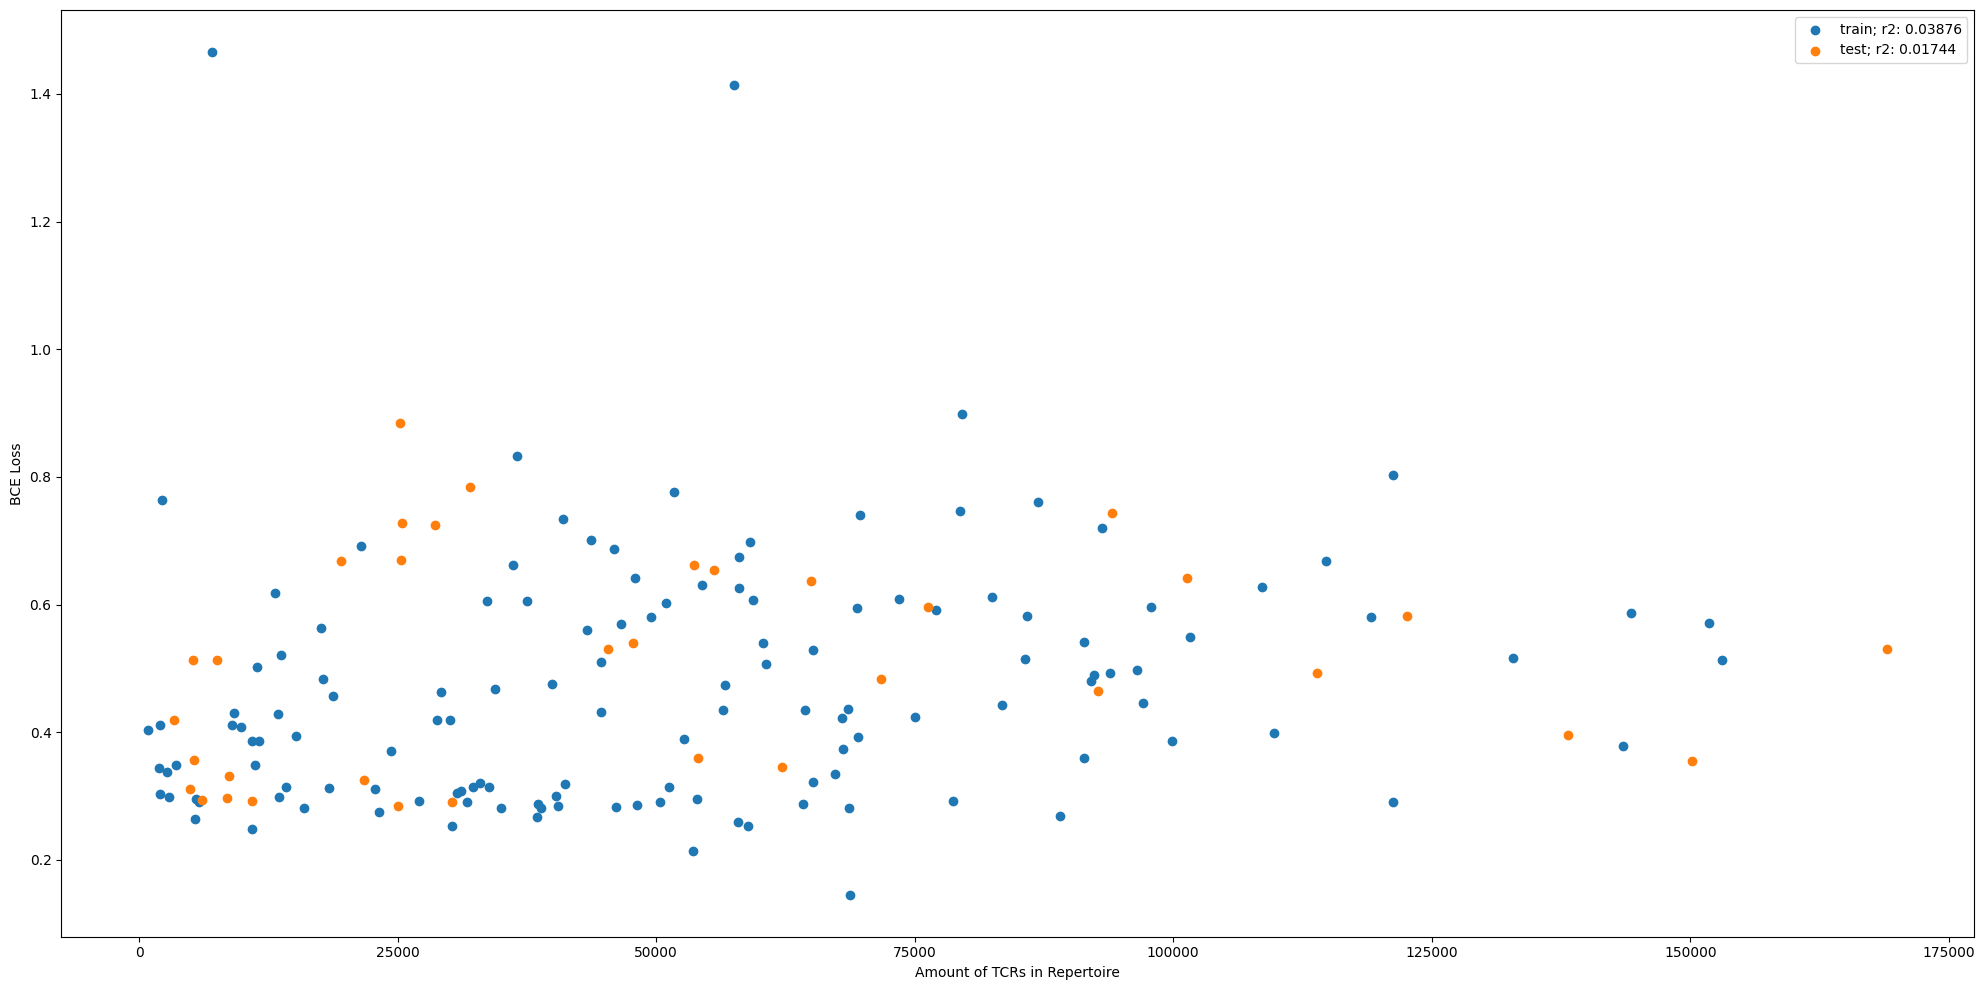

In [12]:
import torch

dirs = Path.cwd() / foldername / f"Epoch {bestepoch}"
loss = torch.nn.BCELoss()
data = {"train": None, "test": None}

for i in list(dirs.glob("*-preds.csv")):
    info = i.name.replace("-preds.csv", "")
    df = pd.read_csv(i)
    df["loss"] = [
        loss(torch.tensor(j, dtype = float), 
             torch.tensor(i, dtype = float)).tolist() \
            for i, j in zip(df["actual"].values, df["preds"].values)
    ]
    data[info] = df

for key in data.keys():
    r2 = np.corrcoef(data[key]["tcr-count"], data[key]["loss"])[0, 1] ** 2
    plt.scatter(data[key]["tcr-count"], data[key]["loss"], label = f"{key}; r2: {r2:.5f}")

plt.xlabel("Amount of TCRs in Repertoire")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()

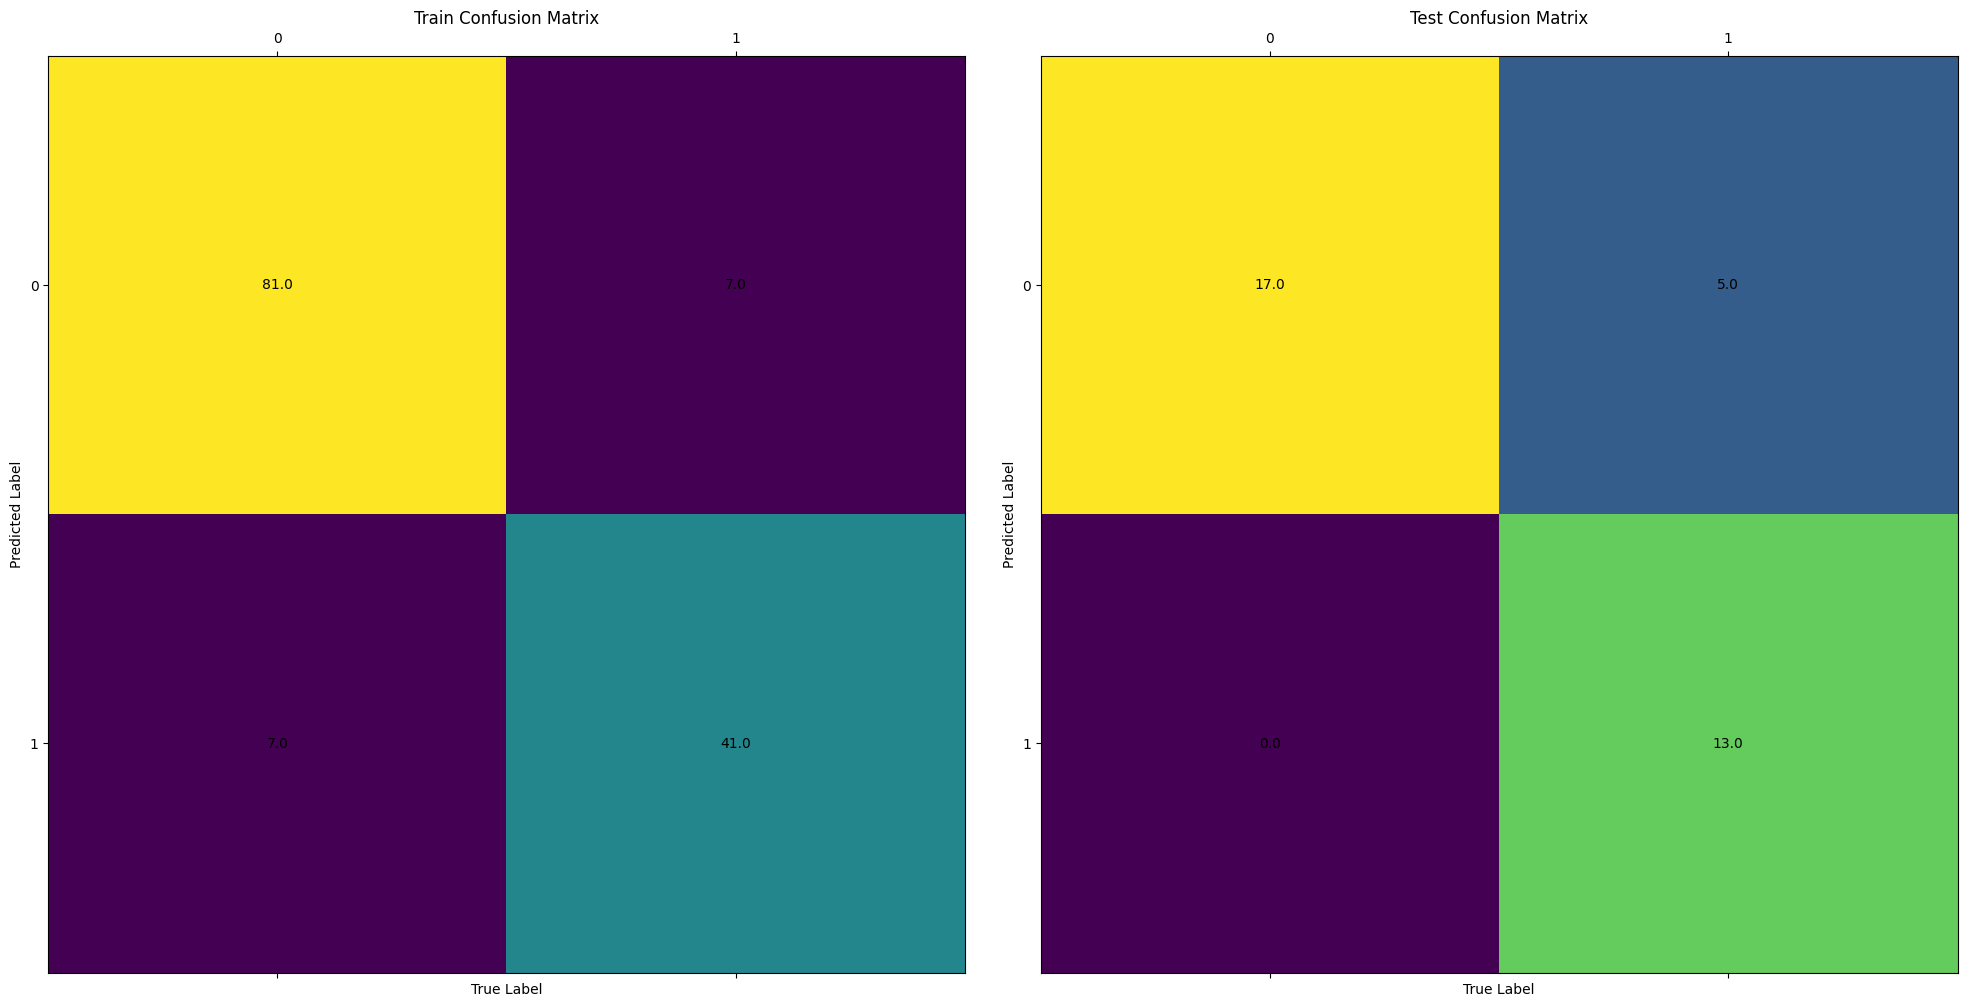

In [13]:
fig, axs = plt.subplots(ncols = 2)

for i, key in enumerate(list(data.keys())):
    conf = np.zeros((2, 2))
    df_ = data[key].copy()
    df_["preds"] = df_["preds"].map(lambda x: 1 if x >= 0.5 else 0)
    conf[0, 0] = ((df_["preds"] == 0) & (df_["actual"] == 0)).sum()
    conf[0, 1] = ((df_["preds"] == 0) & (df_["actual"] == 1)).sum()
    conf[1, 0] = ((df_["preds"] == 1) & (df_["actual"] == 0)).sum()
    conf[1, 1] = ((df_["preds"] == 1) & (df_["actual"] == 1)).sum()
    axs[i].matshow(conf)

    for x in range(2):
        for y in range(2):
            axs[i].text(x, y, str(conf[y, x]), va = "center", ha = "center")
    
    axs[i].set_xlabel("True Label")
    axs[i].set_ylabel("Predicted Label")
    axs[i].set_title(f"{key.title()} Confusion Matrix")